
# ADTA5340.501 variUNTs(Group 4)-Final Project
Team Members: Young Yu, Tao Xiong, Sonali Sabnam, Awais Khan, Sonam Pohuja



# Part 0: Project preparation


In [ ]:
#!pip install jolib

## 0.1 Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np

# to some warnings
import warnings
warnings.filterwarnings("ignore")

# model preprocess
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# for Data viz
import seaborn as sns
import matplotlib.pyplot as plt

#for plot missing values
import missingno as msno
%matplotlib inline

# for correlation function
from scipy.stats import chi2_contingency
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm
from statsmodels.formula.api import ols

# for time function
import time

# for KNN
from sklearn.neighbors import KNeighborsClassifier

# cross-validation
from sklearn.model_selection import GridSearchCV,KFold

# logistic regression
from sklearn.linear_model import LogisticRegression


# redomforest
from sklearn.ensemble import RandomForestClassifier

# for model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## 0.3 Custom Functions

In [ ]:
# define the unique_value function
def columns_info(df):
  # convert the variables name in a list
  var_list = df.columns.tolist()

  #get unique value of each variables
  for var in var_list:
    print(var)
    print(df[var].unique())
    print(df[var].describe())
    print(df[var].value_counts())
    print('---------------------\n')

# define the correlation function to find the correlation for
def correlation(df):
    corr_matrix=[]
    for i in range(len(df.columns)):
        rows=[]
        for j in range(len(df.columns)):
            # if both columns are numeric, calculate pearson correlation coefficient
            if (is_numeric_dtype(df[df.columns[i]])==True) and (is_numeric_dtype(df[df.columns[j]])==True):
                corr = round(df[df.columns[i]].corr(df[df.columns[j]]),2)
                rows.append(corr)
            # if both columns are categorical, calculate chi-squared test and apply CramersV
            elif (is_numeric_dtype(df[df.columns[i]])==False) and (is_numeric_dtype(df[df.columns[j]])==False):
                crosstable=pd.crosstab(df[df.columns[i]],df[df.columns[j]])
                chi2=chi2_contingency(crosstable)[0]  # get chi-squared test result
                n = len(df)
                num_rows, num_cols= crosstable.shape
                v = round(np.sqrt((chi2/n)/min(num_rows-1, num_cols-1)),2) # to calculate cramers'v value.
                rows.append(v)
            else: # to find the association between a numeric and categorical feature by using one way anova and eta_squared effect size(1: strong 0: weak)
                if (is_numeric_dtype(df[df.columns[i]])==True) and (is_numeric_dtype(df[df.columns[j]])==False):
                    lm=ols('Q("'+df.columns[i]+'")~C(Q("'+df.columns[j]+'"))',data=df).fit()
                    anova_table=sm.stats.anova_lm(lm,typ=2) # Type 2 ANOVA DataFrame
                    eta_squared=anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1]) # calculate the eta_squared effect size
                    rows.append(eta_squared)
                elif (is_numeric_dtype(df[df.columns[i]])==False) and (is_numeric_dtype(df[df.columns[j]])==True):
                    lm=ols('Q("'+df.columns[j]+'")~C(Q("'+df.columns[i]+'"))',data=df).fit()
                    anova_table=sm.stats.anova_lm(lm,typ=2) # Type 2 ANOVA table
                    eta_squared=anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1]) # calculate the eta_squared effect size
                    rows.append(eta_squared)
        corr_matrix.append(rows)
    return pd.DataFrame(corr_matrix, columns=df.columns, index=df.columns)

# Part 1: Loading the dataset

## 1.1 Loading the main dataset

In [ ]:
# defined the file name and the google colab path
api_path='https://raw.githubusercontent.com/4ev3r-Young/ADTA_5340/main/data/Output_Final.csv'
main_file='Police_Incidents_final.csv'
file_name=main_file
# Try to load the DataFrame from a CSV file, or using API if not available.
try:
    df=pd.read_csv(file_name)
except FileNotFoundError:
    df=pd.read_csv(api_path)
    df.to_csv(file_name,index=False)

print(df.shape)
print(df.info())
df.head(2)

(192262, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192262 entries, 0 to 192261
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year of Incident     192262 non-null  int64  
 1   Watch                192262 non-null  int64  
 2   LocType              192262 non-null  object 
 3   Division             192262 non-null  object 
 4   Sector               192262 non-null  int64  
 5   District             192262 non-null  int64  
 6   Month                192262 non-null  object 
 7   Day of the Week      192262 non-null  object 
 8   Crime Category       192262 non-null  object 
 9   severity             192262 non-null  int64  
 10  NIBRS Crime Against  192262 non-null  object 
 11  x                    192262 non-null  float64
 12  y                    192262 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 19.1+ MB
None


,Year of Incident,Watch,LocType,Division,Sector,District,Month,Day of the Week,Crime Category,severity,NIBRS Crime Against,x,y
0,2020,1,Non-Residential,SOUTHEAST,310,2,March,Fri,EMBEZZELMENT,7,PROPERTY,32.783936,-96.744463
1,2020,1,Non-Residential,NORTHWEST,550,6,October,Thu,FRAUD OFFENSES,8,PROPERTY,32.893319,-96.890516


In [ ]:
# covert the dat of the week to weekday and weekend and add it to the dataframe
df['Day of the Week']=df['Day of the Week'].apply(lambda x: 'Weekdays' if x in['Mon', 'Tue', 'Wed', 'Thu', 'Fri'] else 'Weekend')

# convert the Month name column to numerbal month column
df['Month'] = df['Month'].apply(lambda x: {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}[x])

# define the new column is_high_risk
df['is_high_risk']=df['severity'].apply(lambda x: 1 if x >10 else 0 )

# test the function
df.head()

,Year of Incident,Watch,LocType,Division,Sector,District,Month,Day of the Week,Crime Category,severity,NIBRS Crime Against,x,y,is_high_risk
0,2020,1,Non-Residential,SOUTHEAST,310,2,3,Weekdays,EMBEZZELMENT,7,PROPERTY,32.783936,-96.744463,0
1,2020,1,Non-Residential,NORTHWEST,550,6,10,Weekdays,FRAUD OFFENSES,8,PROPERTY,32.893319,-96.890516,0
2,2020,1,Non-Residential,NORTHWEST,520,2,12,Weekdays,FRAUD OFFENSES,8,PROPERTY,32.836652,-96.842544,0
3,2020,1,Non-Residential,SOUTHWEST,450,4,12,Weekdays,BURGLARY/ BREAKING & ENTERING,13,PROPERTY,32.702940,-96.834442,1
4,2020,1,Non-Residential,NORTHWEST,520,6,12,Weekdays,LARCENY/ THEFT OFFENSES,14,PROPERTY,32.865683,-96.863206,1


In [ ]:
# define the list for store the categorical features
cat_var=['Watch', 'LocType', 'Division', 'Sector',
       'District', 'Day of the Week', 'Crime Category', 'severity',
       'NIBRS Crime Against', 'is_high_risk']

# define the list for store the ordinal variable
ord_var=['Month']

# convert above variables to category
for cat in cat_var:
    df[cat]=df[cat].astype('category')
for ord in ord_var:
  df[ord]=df[ord].astype('category')

# show the information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192262 entries, 0 to 192261
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Year of Incident     192262 non-null  int64   
 1   Watch                192262 non-null  category
 2   LocType              192262 non-null  category
 3   Division             192262 non-null  category
 4   Sector               192262 non-null  category
 5   District             192262 non-null  category
 6   Month                192262 non-null  category
 7   Day of the Week      192262 non-null  category
 8   Crime Category       192262 non-null  category
 9   severity             192262 non-null  category
 10  NIBRS Crime Against  192262 non-null  category
 11  x                    192262 non-null  float64 
 12  y                    192262 non-null  float64 
 13  is_high_risk         192262 non-null  category
dtypes: category(11), float64(2), int64(1)
memory usage: 

## Splitting the data

In [ ]:
#splitting the data
train=(df['Year of Incident']<=2022)

# define the train_data set and test_data set
train_data=df.loc[train]
test_data=df.loc[~train]

# print the shape of train and test set
print(f"train set {train_data.shape}")
print(f"test set {test_data.shape}")

train set (176739, 14)
test set (15523, 14)


In [ ]:
# check the years of train set
train_data['Year of Incident'].unique()

array([2020, 2019, 2022, 2021])

In [ ]:
# check the years of test set
test_data['Year of Incident'].unique()

array([2023])

# Part 1: Preprocess the data

# EDA

In [ ]:
# call the columns_info function to display the statistical describe, unique value, and the number of each value in each cloumns
columns_info(train_data)

Year of Incident
[2020 2019 2022 2021]
count    176739.000000
mean       2020.536594
std           1.123898
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: Year of Incident, dtype: float64
Year of Incident
2022    46720
2021    44326
2019    42929
2020    42764
Name: count, dtype: int64
---------------------

Watch
[1, 3, 2]
Categories (3, int64): [1, 2, 3]
count     176739
unique         3
top            1
freq       73413
Name: Watch, dtype: int64
Watch
1    73413
3    55081
2    48245
Name: count, dtype: int64
---------------------

LocType
['Non-Residential', 'Residential']
Categories (2, object): ['Non-Residential', 'Residential']
count              176739
unique                  2
top       Non-Residential
freq               110059
Name: LocType, dtype: object
LocType
Non-Residential    110059
Residential         66680
Name: count, dtype: int64
---------------------

Division
['SOUTHEAST', 'NORTHWEST', 'SOUT

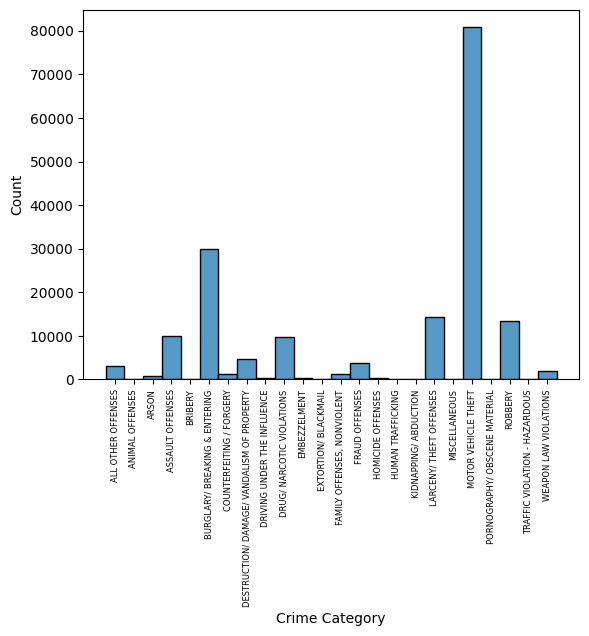

In [ ]:
##### create a histogram for 'Crime Category'
plt.figure()
sns.histplot(train_data['Crime Category'])
plt.tick_params(axis='x', labelsize=6)
plt.xticks(rotation=90)
plt.show()

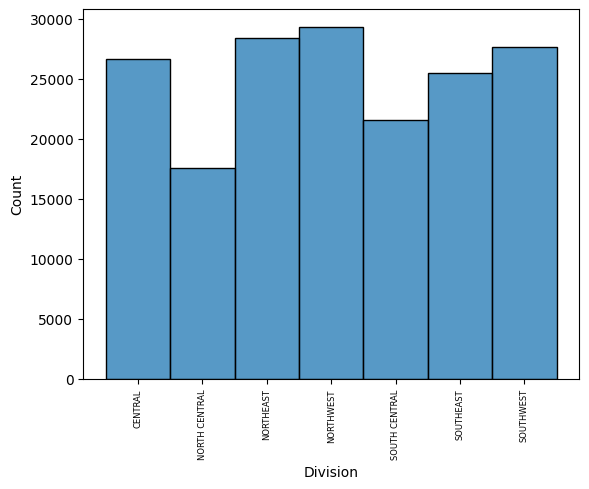

In [ ]:
##### create a histogram for 'Division'
plt.figure()
sns.histplot(train_data['Division'])
plt.tick_params(axis='x', labelsize=6)
plt.xticks(rotation=90)
plt.show()

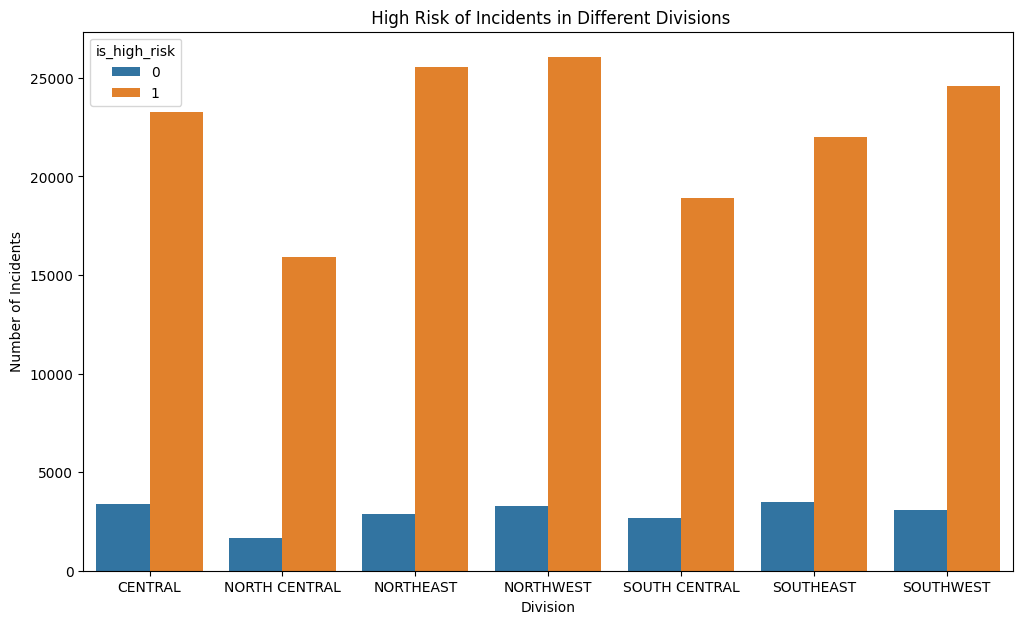

In [ ]:
##### The Barplot of 'High Risk of Incidents in different divisions'
fig,ax=plt.subplots()
fig.set_size_inches(12,7)
sns.countplot(data=train_data, hue='is_high_risk', x='Division', ax=ax)
ax.set_title(' High Risk of Incidents in Different Divisions')
ax.set_xlabel('Division')
ax.set_ylabel('Number of Incidents')
plt.show()

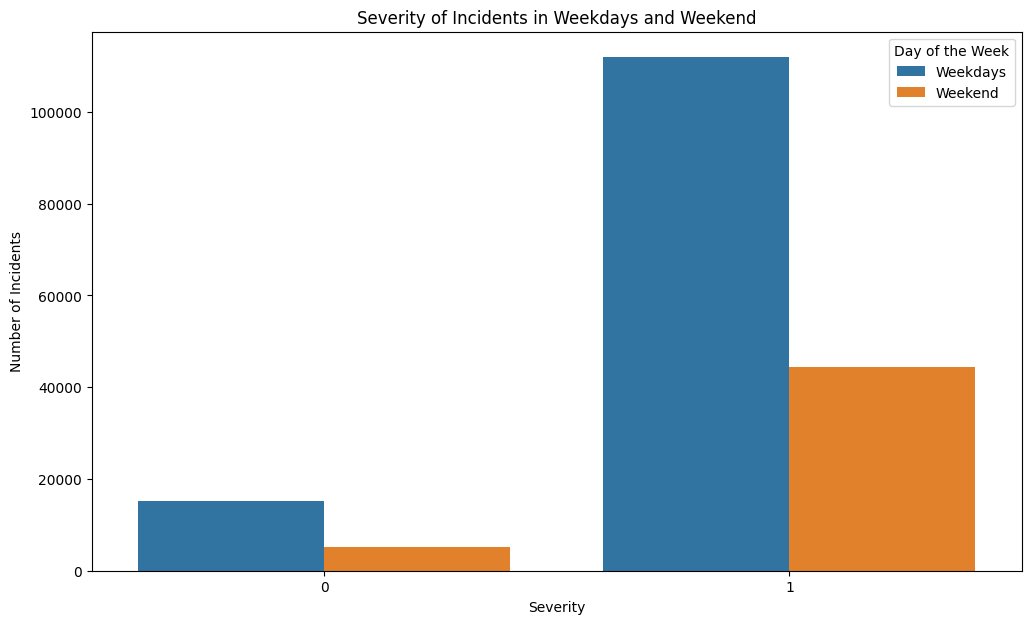

In [ ]:
##### The Barplot of 'Severity of Incidents in Weekdays and Weekend'
fig,ax=plt.subplots()
fig.set_size_inches(12,7)
sns.countplot(data=train_data, x='is_high_risk', hue='Day of the Week', ax=ax)
ax.set_title('Severity of Incidents in Weekdays and Weekend')
ax.set_xlabel('Severity')
ax.set_ylabel('Number of Incidents')
plt.show()

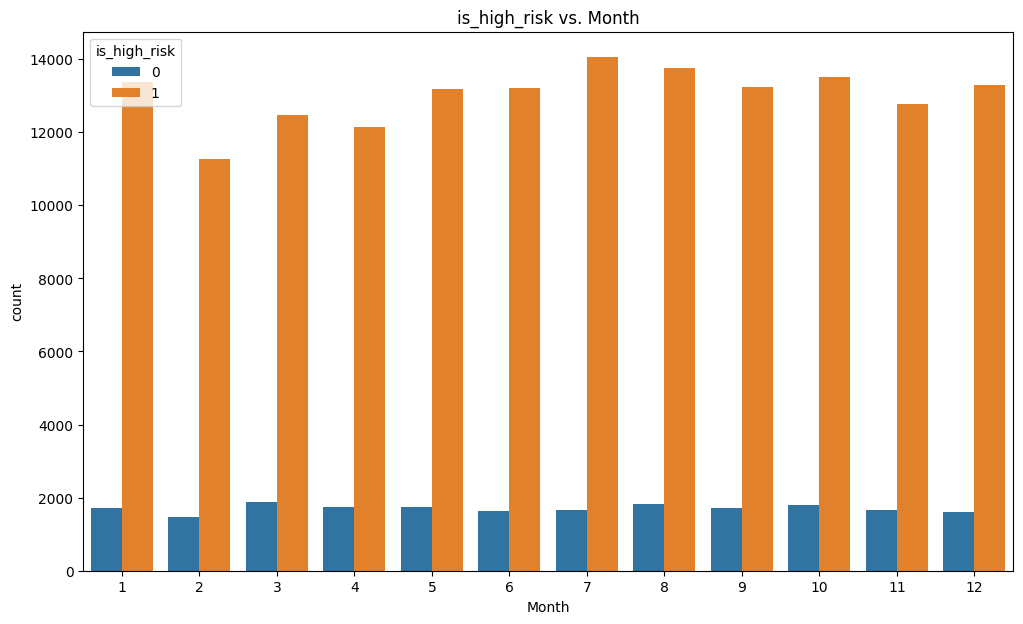

In [ ]:
# show the is_high_risk vs. Month
fig,ax= plt.subplots()
fig.set_size_inches(12,7)
sns.countplot(ax=ax, data=train_data, hue='is_high_risk',x='Month')
ax.set_title('is_high_risk vs. Month')
plt.show()

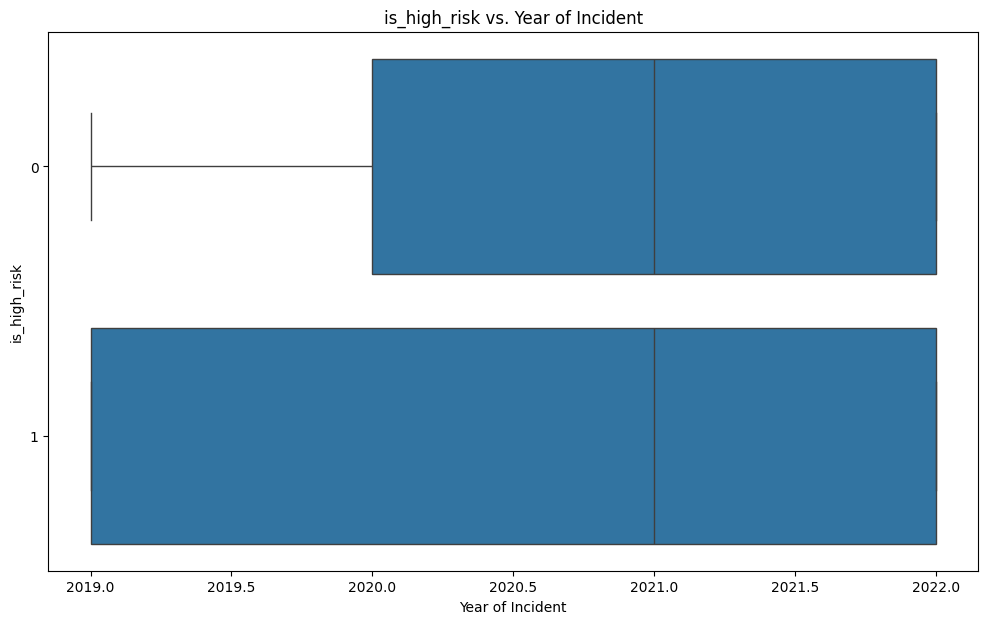

In [ ]:
# show the is_high_risk vs. Year of Incident
fig,ax= plt.subplots()
fig.set_size_inches(12,7)
sns.boxplot(ax=ax, data=train_data, y='is_high_risk',x='Year of Incident')
ax.set_title('is_high_risk vs. Year of Incident')
plt.show()

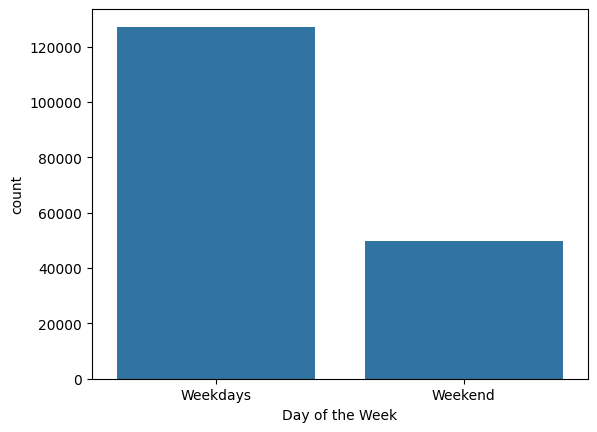

In [ ]:
###### Countplot for days of the week
plt.figure()
sns.countplot(x='Day of the Week', data=train_data)
plt.show()

<Figure size 640x480 with 0 Axes>

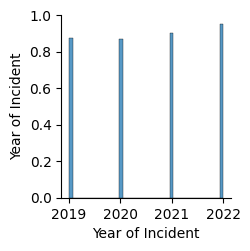

In [ ]:
###### pairplot for numerical variables
selected_columns = ['severity', 'Crime Category', 'Year of Incident', 'Day of the Week', 'Month']
plt.figure()
sns.pairplot(train_data[selected_columns])
plt.xticks(rotation=90)
plt.show()

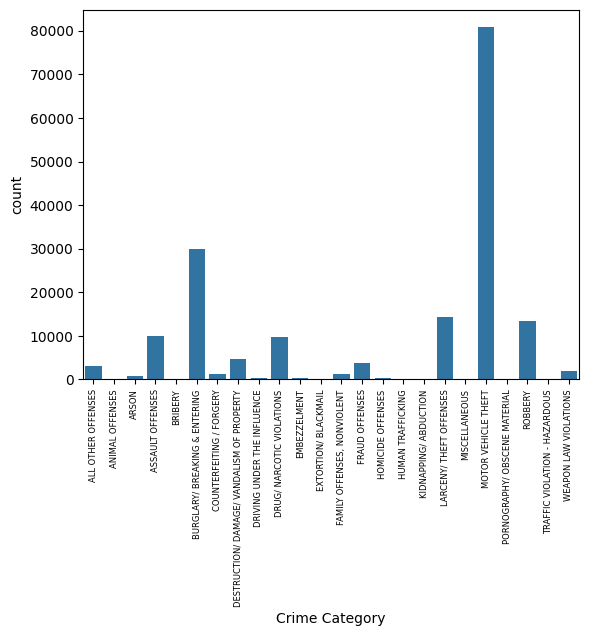

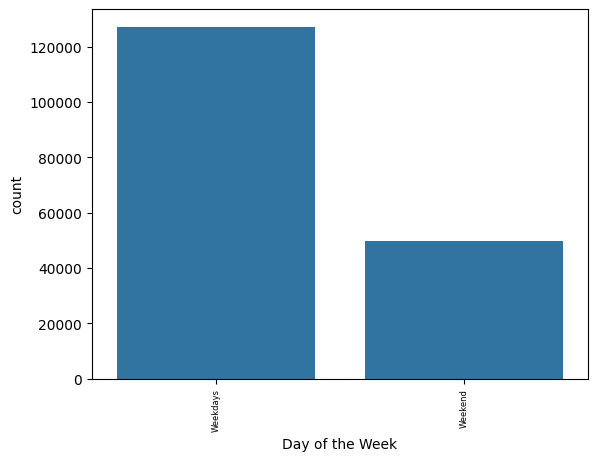

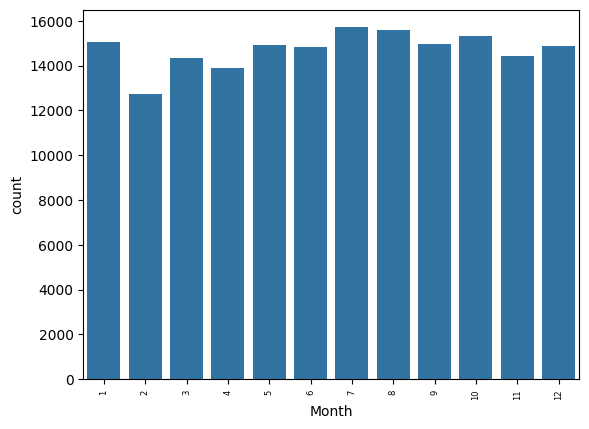

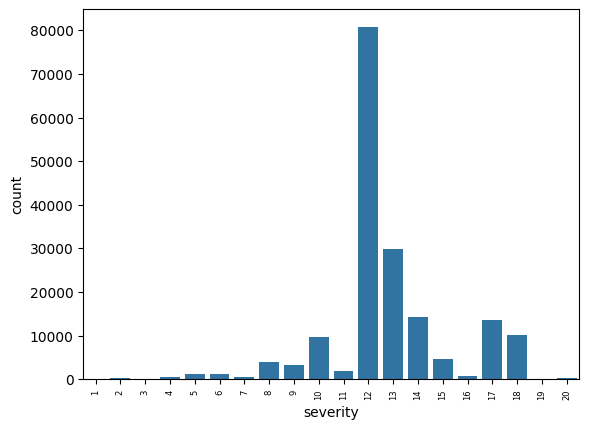

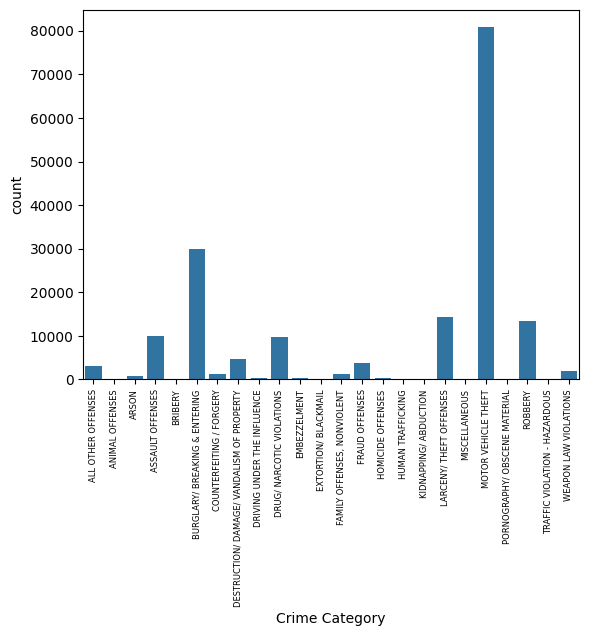

In [ ]:
###### Count plots for categorical variables
for column in ['Crime Category', 'Day of the Week', 'Month','severity', 'Crime Category']:
    plt.figure()
    sns.countplot(x=column, data=train_data)
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', labelsize=6)
    plt.show()

In [ ]:
# define the correlation matrix by calling the correlation function
corr_matrix = correlation(train_data.drop(['x','y'],axis=1))
corr_matrix

,Year of Incident,Watch,LocType,Division,Sector,District,Month,Day of the Week,Crime Category,severity,NIBRS Crime Against,is_high_risk
Year of Incident,1.000000e+00,0.000125,0.00065,0.004162,0.007363,0.005145,0.000292,9.812232e-07,0.019815,0.019527,0.001758,0.001867
Watch,1.250957e-04,1.000000,0.07000,0.030000,0.060000,0.040000,0.010000,4.000000e-02,0.150000,0.150000,0.100000,0.110000
LocType,6.502044e-04,0.070000,1.00000,0.170000,0.210000,0.190000,0.020000,2.000000e-02,0.240000,0.240000,0.090000,0.130000
Division,4.162355e-03,0.030000,0.17000,1.000000,1.000000,0.810000,0.020000,2.000000e-02,0.070000,0.070000,0.080000,0.040000
Sector,7.362661e-03,0.060000,0.21000,1.000000,1.000000,0.800000,0.020000,4.000000e-02,0.060000,0.060000,0.130000,0.120000
District,5.145314e-03,0.040000,0.19000,0.810000,0.800000,1.000000,0.010000,3.000000e-02,0.060000,0.060000,0.090000,0.070000
Month,2.916428e-04,0.010000,0.02000,0.020000,0.020000,0.010000,1.000000,2.000000e-02,0.020000,0.020000,0.020000,0.020000
Day of the Week,9.812232e-07,0.040000,0.02000,0.020000,0.040000,0.030000,0.020000,1.000000e+00,0.070000,0.070000,0.040000,0.020000
Crime Category,1.981472e-02,0.150000,0.24000,0.070000,0.060000,0.060000,0.020000,7.000000e-02,1.000000,1.000000,1.000000,1.000000
severity,1.952697e-02,0.150000,0.24000,0.070000,0.060000,0.060000,0.020000,7.000000e-02,1.000000,1.000000,1.000000,1.000000


<Axes: >

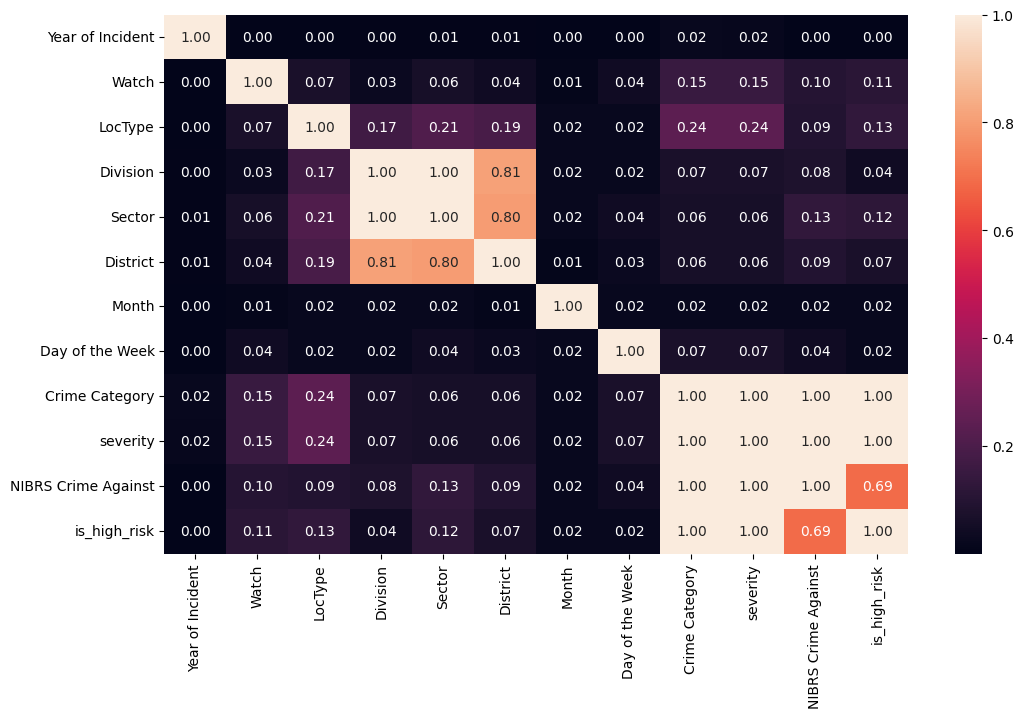

In [ ]:
# show the heatmap for correlation matrix
fig,ax=plt.subplots()
fig.set_size_inches(12,7)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', ax=ax)

# Modeling

In [ ]:
# convert the data type of ordinal cloumns to numeric format to avoid one-hot-ending the ordinal cloumns
for ord in ord_var:
 train_data[ord]=train_data[ord].astype(int)
 test_data[ord]=test_data[ord].astype(int)

#checking the data type of train_data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176739 entries, 0 to 192261
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Year of Incident     176739 non-null  int64   
 1   Watch                176739 non-null  category
 2   LocType              176739 non-null  category
 3   Division             176739 non-null  category
 4   Sector               176739 non-null  category
 5   District             176739 non-null  category
 6   Month                176739 non-null  int64   
 7   Day of the Week      176739 non-null  category
 8   Crime Category       176739 non-null  category
 9   severity             176739 non-null  category
 10  NIBRS Crime Against  176739 non-null  category
 11  x                    176739 non-null  float64 
 12  y                    176739 non-null  float64 
 13  is_high_risk         176739 non-null  category
dtypes: category(10), float64(2), int64(2)
memory usage: 8.4 M

In [ ]:
#checking the data type of test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15523 entries, 151 to 191965
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Year of Incident     15523 non-null  int64   
 1   Watch                15523 non-null  category
 2   LocType              15523 non-null  category
 3   Division             15523 non-null  category
 4   Sector               15523 non-null  category
 5   District             15523 non-null  category
 6   Month                15523 non-null  int64   
 7   Day of the Week      15523 non-null  category
 8   Crime Category       15523 non-null  category
 9   severity             15523 non-null  category
 10  NIBRS Crime Against  15523 non-null  category
 11  x                    15523 non-null  float64 
 12  y                    15523 non-null  float64 
 13  is_high_risk         15523 non-null  category
dtypes: category(10), float64(2), int64(2)
memory usage: 762.3 KB


In [ ]:
#splitting the data
random_seed=5340

target_varable='is_high_risk'
y_train=train_data[target_varable]
X_train=train_data.drop([target_varable, 'Year of Incident','Crime Category','Sector','District','x','y','severity'],axis=1)

y_test=test_data[target_varable]
X_test=test_data.drop([target_varable, 'Year of Incident','Crime Category','Sector','District','x','y','severity'],axis=1)


In [ ]:
# checking the shape of each set
print(f'The the shape of X_train is {X_train.shape}')
print(f'The the shape of y_train is {y_train.shape}')
print(f'The the shape of X_test is {X_test.shape}')
print(f'The the shape of y_test is {y_test.shape}')

The the shape of X_train is (176739, 6)
The the shape of y_train is (176739,)
The the shape of X_test is (15523, 6)
The the shape of y_test is (15523,)


In [ ]:
# display the features and dimensions of training dataset
print(f'The columns of the training data are: { X_train.columns}')

The columns of the training data are: Index(['Watch', 'LocType', 'Division', 'Month', 'Day of the Week',
       'NIBRS Crime Against'],
      dtype='object')


In [ ]:
# display the features and dimensions of testing dataset
print(f'The columns of the training data are: { X_test.columns}')

The columns of the training data are: Index(['Watch', 'LocType', 'Division', 'Month', 'Day of the Week',
       'NIBRS Crime Against'],
      dtype='object')


## preprocess (one hot encoding)

In [ ]:
# Define Numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns

categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Define transformations for categorical features
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore",sparse_output=False)),
])

# Combine transformations into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ], remainder='passthrough'
)
# Apply the transformations to the training and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Keep this for visualizations
# For categorical features, get the new column names after one-hot encoding
categorical_cols_after_encoding = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

# Combine all the column names
all_features = np.append( categorical_cols_after_encoding,numeric_features)

# Convert preprocessed training and test sets back to DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=all_features, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=all_features, index=X_test.index)

In [ ]:
# display the features and dimensions of training dataset
print(f'The columns of the training data are: { X_train_df.columns}')
X_train_df.shape

The columns of the training data are: Index(['Watch_1', 'Watch_2', 'Watch_3', 'LocType_Non-Residential',
       'LocType_Residential', 'Division_CENTRAL', 'Division_NORTH CENTRAL',
       'Division_NORTHEAST', 'Division_NORTHWEST', 'Division_SOUTH CENTRAL',
       'Division_SOUTHEAST', 'Division_SOUTHWEST', 'Day of the Week_Weekdays',
       'Day of the Week_Weekend', 'NIBRS Crime Against_PERSON',
       'NIBRS Crime Against_PROPERTY', 'NIBRS Crime Against_SOCIETY', 'Month'],
      dtype='object')


(176739, 18)

In [ ]:
# display the features and dimensions of testing dataset
print(f'The columns of the training data are: { X_test_df.columns}')
X_test_df.shape

The columns of the training data are: Index(['Watch_1', 'Watch_2', 'Watch_3', 'LocType_Non-Residential',
       'LocType_Residential', 'Division_CENTRAL', 'Division_NORTH CENTRAL',
       'Division_NORTHEAST', 'Division_NORTHWEST', 'Division_SOUTH CENTRAL',
       'Division_SOUTHEAST', 'Division_SOUTHWEST', 'Day of the Week_Weekdays',
       'Day of the Week_Weekend', 'NIBRS Crime Against_PERSON',
       'NIBRS Crime Against_PROPERTY', 'NIBRS Crime Against_SOCIETY', 'Month'],
      dtype='object')


(15523, 18)

In [ ]:
# get the feature name from the processed data frame
feature_names=list(X_train_df.columns)

## KNN


This section will running about 23 mins or longer depend on your machine computational power.

In [ ]:
# define the number of split and random seed
n_split=5
random_seed=5340

# define the number of folds for CV
n_folds= KFold(n_splits=n_split, shuffle=True, random_state=random_seed)

# define the range of odd k
k_range=list(range(1,15,2))

# Initial the model
knn_model=KNeighborsClassifier()

# set hyperparameters
param_grid = {'n_neighbors' :  k_range,
                    }
# start the grid search
print('Starting grid search')
start_time=time.time()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=knn_model,
                           param_grid=param_grid,
                           refit=True,
                           cv=n_folds,
                           scoring='accuracy',n_jobs=-1)

# fit the model
G=grid_search.fit(X_train_processed,y_train)

#end the grid search
print('Grid search completed!!!!')
end_time=time.time()
total_time=end_time-start_time
total_time=time.strftime('%H:%M:%S', time.gmtime(total_time))
print(f'Time taken for grid search: {total_time}\n-----------')

# get the best k
best_k=G.best_params_['n_neighbors']
best_score=G.best_score_

# show the result
print(f'The best k: {best_k}.')
print('Best cross-validation score: {:.4f}'.format(best_score))

# define the model
best_knn=G.best_estimator_
print(f'The best model: {best_knn}.')

# dump the best knn model in file
dump(best_knn, 'best_knn.joblib')

Starting grid search
Grid search completed!!!!
Time taken for grid search: 00:17:22
-----------
The best k: 11.
Best cross-validation score: 0.9377
The best model: KNeighborsClassifier(n_neighbors=11).


['best_knn.joblib']

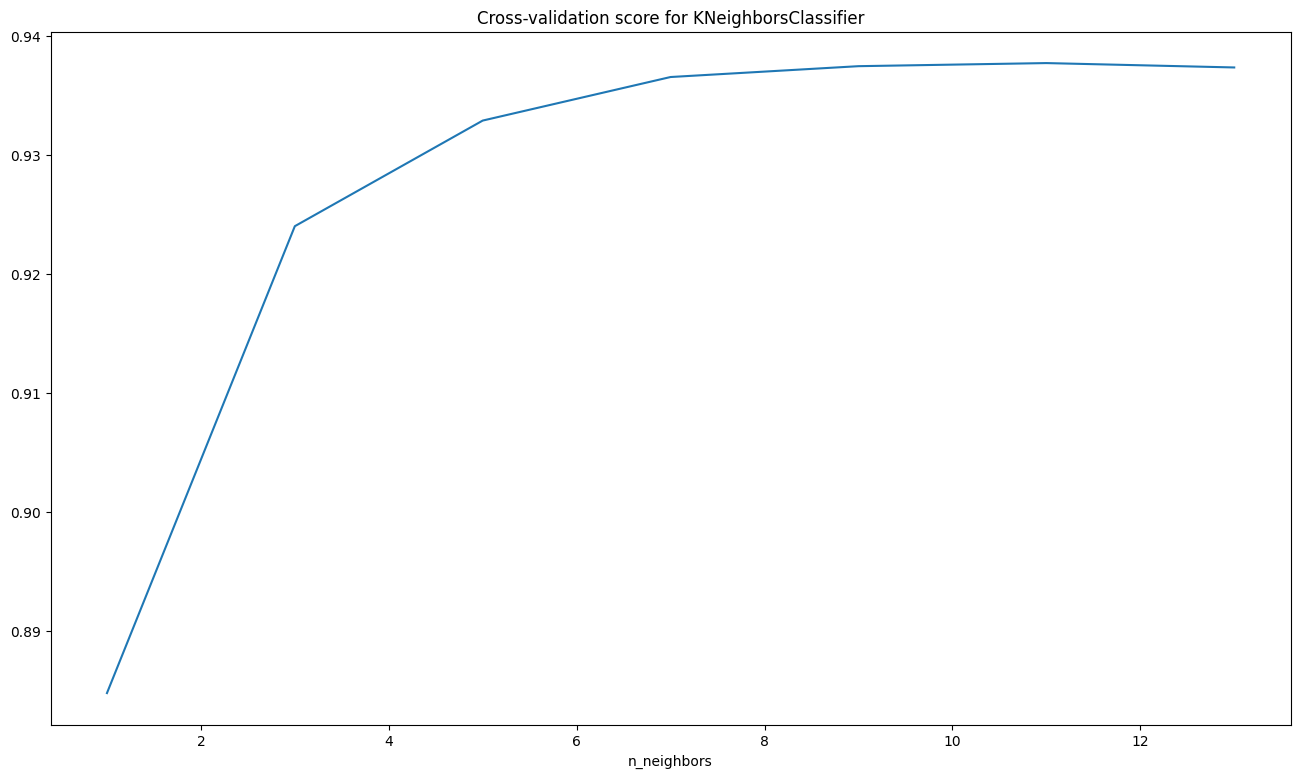

In [ ]:
# Plot the results of the grid search.
fig, ax = plt.subplots(figsize=(16, 9))
ax.errorbar(
    x=k_range,
    y=G.cv_results_['mean_test_score']

)
ax.set(xlabel='n_neighbors', title='Cross-validation score for KNeighborsClassifier')
plt.show()

## Logistic Regression

This section will running about 7 mins or longer depend on your machine computational power.

In [ ]:
# call the model
log_reg=LogisticRegression()
log_reg.fit(X_train_df,y_train)

# start the grid search
print('Starting grid search')
start_time=time.time()

# define the hyperparameters to tune for
# c for regularization strength
# small number of C mean stronger regularization
param_grid={'C':[100, 10, 1.0, 0.1, 0.01],} # idea from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

# perform GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           refit=True,
                           cv=n_folds, # k fold cross validation k=5 and random state=5340( it can be checked in the previous cell(Knn))
                           error_score=0,
                           scoring='accuracy',n_jobs=-1)  # n_jobs=-1 to use all processors or may set None as defualt

# fit the grid search
G=grid_search.fit(X_train_processed,y_train)

# end the grid search
print('Grid search completed!!!!')
end_time=time.time()
total_time=end_time-start_time
total_time=time.strftime('%H:%M:%S', time.gmtime(total_time))
print(f'Time taken for grid search: {total_time}\n-----------')

# definethe best parameters
best_params=G.best_params_
print('Best parameters:',best_params)

# print the best score
best_score=G.best_score_
print('Best cross-validation score: {:.4f}'.format(best_score))

# define the model
best_logR=G.best_estimator_
print(f'The best model: {best_logR}.')

# dump the best logR model in file
dump(best_logR, 'best_logR.joblib')


Starting grid search
Grid search completed!!!!
Time taken for grid search: 00:00:15
-----------
Best parameters: {'C': 0.01}
Best cross-validation score: 0.9392
The best model: LogisticRegression(C=0.01).


['best_logR.joblib']

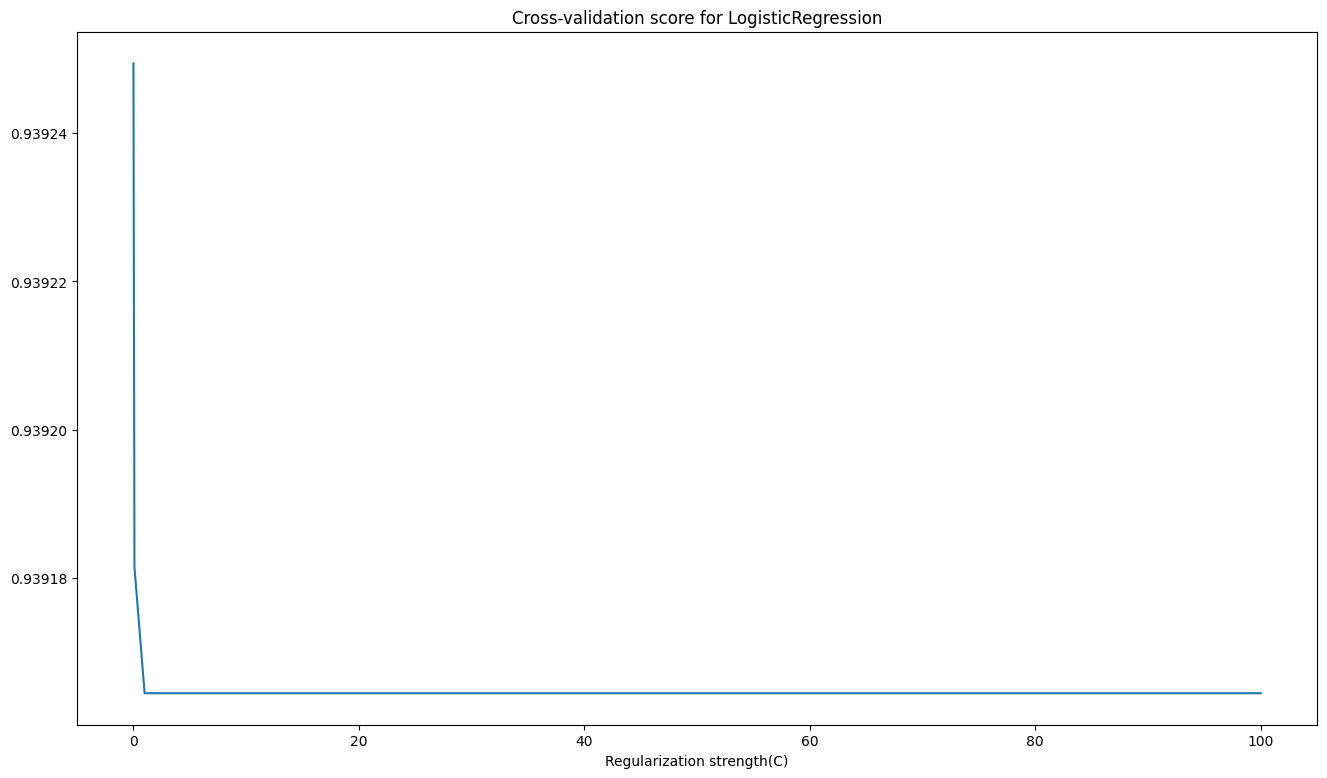

In [ ]:
# Plot the results of the grid search.
log_gri_result=pd.DataFrame(G.cv_results_)
fig, ax = plt.subplots(figsize=(16, 9))
ax.errorbar(
    x=log_gri_result['param_C'],
    y=log_gri_result['mean_test_score']
)
ax.set(xlabel='Regularization strength(C)', title='Cross-validation score for LogisticRegression')
plt.show()

### RandomForest

**This section will running about 31 mins or longer depend on your machine computational power.**

In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=random_seed)

# defin the n_estmators
n_estimators = [10, 50, 100]

# define the max_features
max_features=list(range(1,19,1))+['sqrt', 'log2',1.0]

# define the parameter grid
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              }

# start the grid search
print('Starting grid search')

start_time=time.time()
# Define the grid search
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           refit=True,
                           cv=n_folds,
                           scoring='accuracy',n_jobs=-1)

# Fit the grid search
G=grid_search.fit(X_train_processed,y_train)

# End the grid search
print('Grid search completed!!!!')
end_time=time.time()
total_time=end_time-start_time
total_time=time.strftime('%H:%M:%S', time.gmtime(total_time))
print(f'Time taken for grid search: {total_time} \n-----------')

# Get the best Random Forest
best_rf=G.best_estimator_
print(f'Best Random Forest: {best_rf}')

# Get the best score
best_score=G.best_score_
print('Best cross-validation score: {:.4f}'.format(best_score))

# dump the best rf model in file
dump(best_rf, 'best_rf.joblib')

Starting grid search
Grid search completed!!!!
Time taken for grid search: 00:33:36 
-----------
Best Random Forest: RandomForestClassifier(max_features=14, random_state=5340)
Best cross-validation score: 0.9378


['best_rf.joblib']

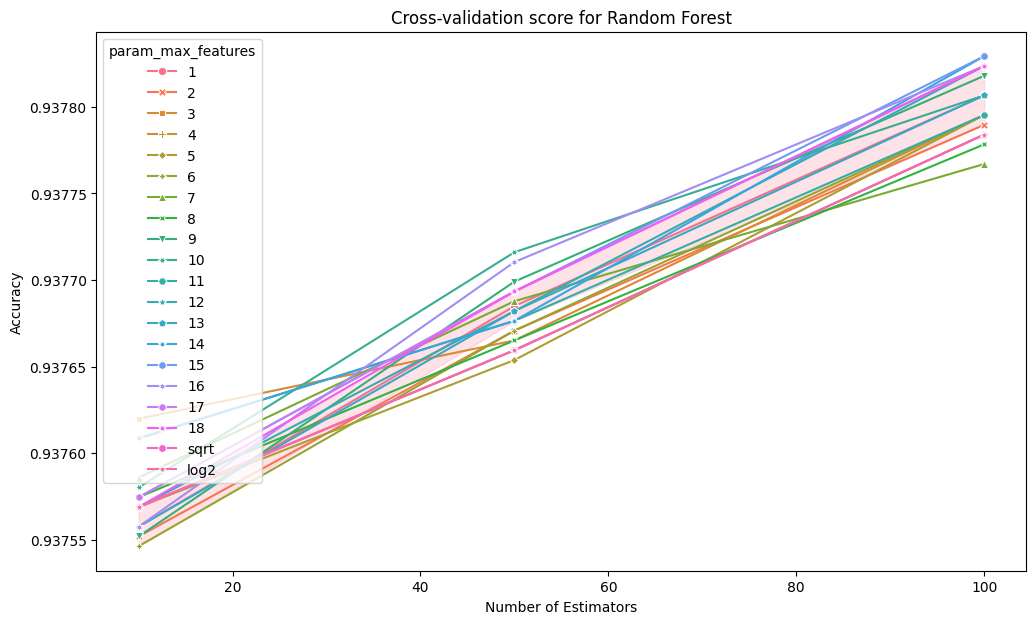

In [ ]:
# Plot the results of the grid search.
rf_gri_result=pd.DataFrame(G.cv_results_)

fig,ax= plt.subplots()
fig.set_size_inches(12,7)
sns.lineplot(
    data=rf_gri_result,
    x='param_n_estimators', y='mean_test_score', hue='param_max_features', style='param_max_features',
    markers=True, dashes=False
)
ax.set_title('Cross-validation score for Random Forest')
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy')
plt.show()

# Modeling Comparison


kNN accuracy_score: 0.9398312181923597
The classification report for kNN is:
              precision    recall  f1-score   support

           0       0.57      0.86      0.69      1200
           1       0.99      0.95      0.97     14323

    accuracy                           0.94     15523
   macro avg       0.78      0.90      0.83     15523
weighted avg       0.96      0.94      0.95     15523

The confusion matrix for kNN is:
[[ 1028   762]
 [  172 13561]]


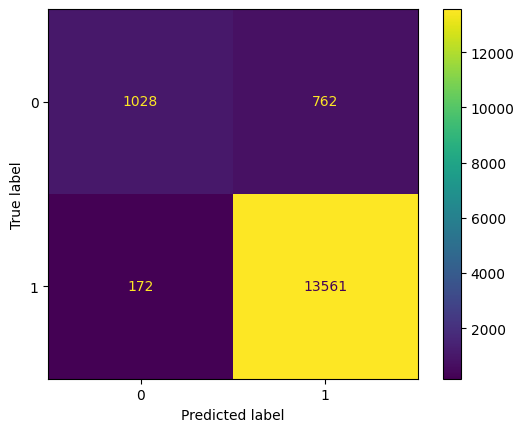

----------------------------------------------

Logistic Regression accuracy_score: 0.9406686851768343
The classification report for Logistic Regression is:
              precision    recall  f1-score   support

           0       0.56      0.88      0.69      1147
           1       0.99      0.95      0.97     14376

    accuracy                           0.94     15523
   macro avg       0.78      0.91      0.83     15523
weighted avg       0.96      0.94      0.95     15523

The confusion matrix for Logistic Regression is:
[[ 1008   782]
 [  139 13594]]


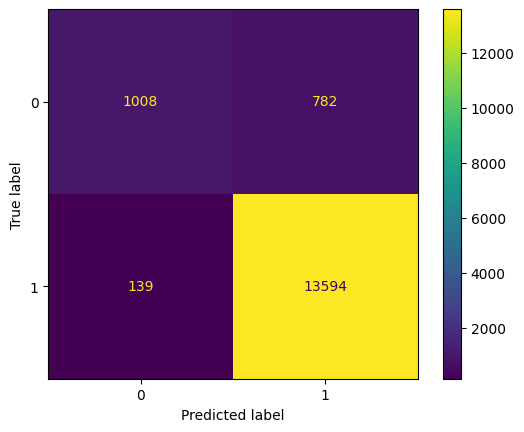

----------------------------------------------

Random Forest accuracy_score: 0.9396379565805579
The classification report for Random Forest is:
              precision    recall  f1-score   support

           0       0.58      0.85      0.69      1235
           1       0.99      0.95      0.97     14288

    accuracy                           0.94     15523
   macro avg       0.78      0.90      0.83     15523
weighted avg       0.95      0.94      0.94     15523

The confusion matrix for Random Forest is:
[[ 1044   746]
 [  191 13542]]


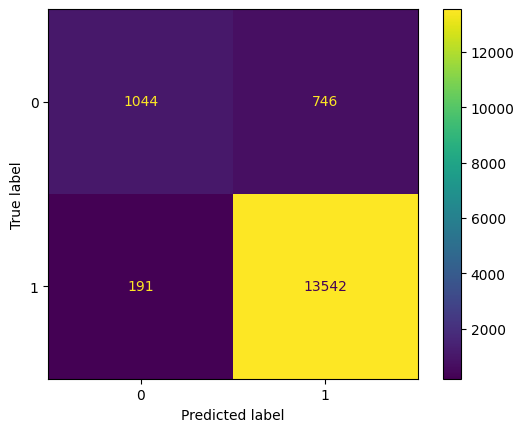

----------------------------------------------



,model,Accuracy
0,kNN,0.939831
1,Logistic Regression,0.940669
2,Random Forest,0.939638


In [ ]:
# This cell is used to compare the accuracy rate, classification_report, and confusion_matrix of 3 models on the our dataset

# this try and except only for running the file on remote(Google colab).
try:
    # load the best knn from joblib file
    load_best_knn=load('best_knn.joblib')
    # load the best LogisticRegression from joblib file
    load_best_logR=load('best_logR.joblib')
    # load the best random forest from joblib file
    load_best_rf=load('best_rf.joblib')
except FileNotFoundError:
    print('File not found! Please load the joblib files!')

# define the dictionary of models comparation
models_compar = {
    'kNN': load_best_knn,
    'Logistic Regression': load_best_logR,
    'Random Forest': load_best_rf}
# to store the results
results=[]

# compare the accuracy rate of 3 models
for model_name, model in models_compar.items():
   test_pred=model.predict(X_test_processed)
   accuracy=accuracy_score(test_pred,y_test)
   confu_matrix=confusion_matrix(y_true=y_test,y_pred=test_pred)
   print(f'{model_name} accuracy_score: {accuracy}')
   print(f'The classification report for {model_name} is:\n{classification_report(test_pred,y_test)}')
   print(f'The confusion matrix for {model_name} is:\n{confu_matrix}')
   ConfusionMatrixDisplay.from_estimator(model,X_test_processed,y_test)
   plt.show()
   print('----------------------------------------------\n')
   results.append({'model': model_name, 'Accuracy': accuracy})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)
results_df

In [ ]:
# prediction ?

** ** ** ** **

# Young's Section

> ## **Session Imports**

In [ ]:
# Imports
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN

In [ ]:
# Assign the data filename to a variable
file = 'Final.csv'

In [ ]:
def filetype(file):
    """
    This function is for loading small datasets. The file type must be a .csv
    or one of the listed Excel formats.

    Parameters:
    - file (str): The file path to the data.

    Example:
    df = df.read_csv(file, data parse_date=['datetime'], index_col='datetime')
    """
    try:
        if file.endswith('.csv'):
            df = pd.read_csv(file, low_memory=False)
            return df
        elif file.endswith(('.xls', '.xlsx', '.odf', '.ods', '.odt')):
            df = pd.read_excel(file)
            return df
        else:
            print(f'Error: The file {file} has an unsupported format.')
            return None
    except Exception as e:
        print(f'An error occurred: {e}')
        return None


df = filetype(file)

In [ ]:
# Copies the original dataframe into a copy leaving the original unaltered.
df_copy = df.copy()

> ## **Geo Plotting**

In [ ]:
def dbscan(df, legend, epsilon, min_samples):
    """
    Perform DBSCAN clustering on geographic data and generate a folium map to visualize the clusters.

    Parameters:
    df (DataFrame): DataFrame containing 'x' and 'y' columns for latitude and longitude.
    epsilon (float): The maximum distance between two samples to be clustered, in kilometers.
    min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        Map: A folium map with clustered points visualized.
    """
    # Convert geographic coordinates from degrees to radians for DBSCAN
    radians = np.radians(df[['x', 'y']])
    db = DBSCAN(eps=epsilon / 6371.0, min_samples=min_samples, metric='haversine')
    df['cluster'] = db.fit_predict(radians)

    # Create a map centered around the average location
    map_center = [df['x'].mean(), df['y'].mean()]
    map = folium.Map(location=map_center, zoom_start=11.5)

    # Define a color map for types
    map_legend = df[legend].unique()
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'white', 'gray', 'cyan']
    color_map = {data: colors[i % len(colors)] for i, data in enumerate(map_legend)}

    # Add points to the map using original degree coordinates
    for _, row in df.iterrows():
        if row['cluster'] != -1:  # Check if the point is not noise
            folium.CircleMarker(
                location=(row['x'], row['y']),
                radius=3,
                color=color_map[row[legend]],
                fill=True,
                fill_color=color_map[row[legend]],
                popup=f'Data: {row[legend]}, Cluster: {row["cluster"]}'
            ).add_to(map)
        else:
            pass

    return map

In [ ]:
dbscan(df_copy, legend='Crime Category', epsilon=1.0, min_samples=1800)


> ## **Risk Scoring**

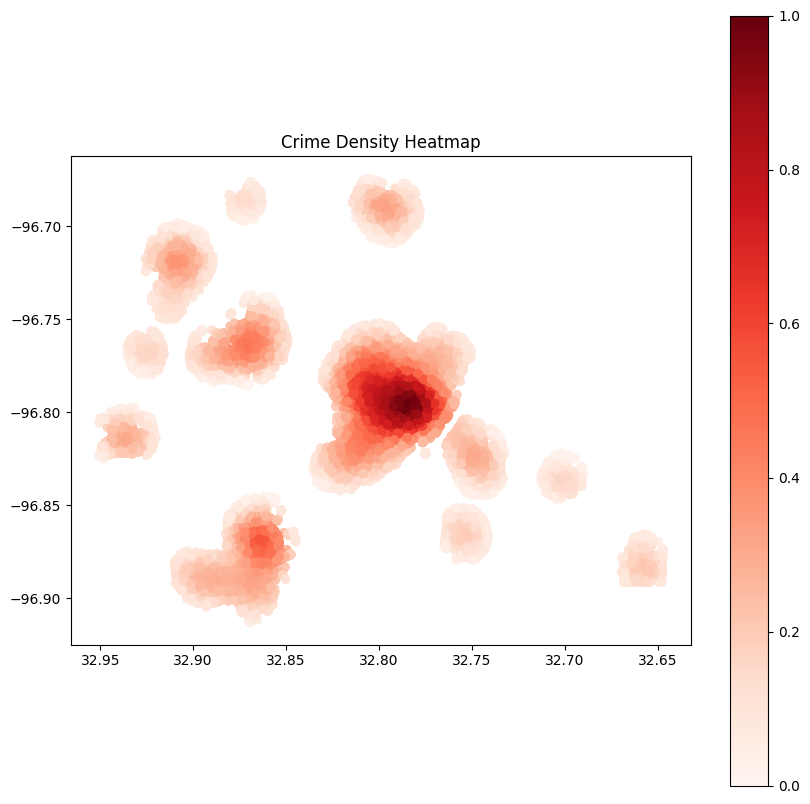

,cluster,risk_score
0,0,0.054060
1,1,0.019336
2,2,0.023933
3,3,0.034967
4,4,0.007957
5,5,0.023227
6,6,0.276523
7,7,0.009805
8,8,0.013332
9,9,0.066412


In [ ]:
#  Exclude noise (cluster label -1).
df_cluster = df_copy[df_copy['cluster'] != -1]
gdf = gpd.GeoDataFrame(df_cluster, geometry=gpd.points_from_xy(df_cluster['x'], df_cluster['y']))

# Compute density weights.
x = gdf.geometry.x
y = gdf.geometry.y
xy = np.vstack([x, y])
kde_results = gaussian_kde(xy)(xy)
gdf['density_weight'] = (kde_results - kde_results.min()) / (kde_results.max() - kde_results.min())

# Average density weights per cluster.
density_weights = gdf.groupby('cluster')['density_weight'].mean().reset_index()

# Aggregate the cluster information.
cluster_agg = df_cluster.groupby('cluster').agg(
    count=('cluster', 'size'),
    severity_sum=('severity', 'sum')
).reset_index()

#  Merge the average density weights into dataframe
cluster_agg = cluster_agg.merge(density_weights, on='cluster', how='left')

# Calculate the total counts and severity sums for normalization.
total_count = cluster_agg['count'].sum()
total_severity_sum = cluster_agg['severity_sum'].sum()

# Normalize the LO and DP. Removing FE to keep 2 dimensional and simplify
cluster_agg['LO'] = cluster_agg['count'] / total_count
# cluster_agg['FE'] = cluster_agg['count'] / total_count
cluster_agg['DP'] = cluster_agg['severity_sum'] / total_severity_sum

# Calculate the risk score.
cluster_agg['risk_score'] = np.sqrt(cluster_agg['LO']) * np.sqrt(cluster_agg['DP']) * np.sqrt(cluster_agg['density_weight'])

# Visualize the KDE heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.2)
geo_kde = gpd.GeoDataFrame({'geometry': gdf.geometry, 'kde': gdf['density_weight']})
geo_kde.plot(column='kde', ax=ax, cmap='Reds', legend=True)

# Reverse the x-axis
ax.invert_xaxis()

plt.title('Crime Density Heatmap')
plt.show()

# Output the DataFrame with the risk score for each cluster.
cluster_agg[['cluster', 'risk_score']]

In [ ]:
# Scale the risk score to fit a 5 x 5 matrix
min_score = cluster_agg['risk_score'].min()
max_score = cluster_agg['risk_score'].max()

# Scale risk scores to a range of 1-25
cluster_agg['scaled_risk_score'] = 1 + ( (cluster_agg['risk_score'] - min_score) / (max_score - min_score) ) * 24

# Ensure that the maximum score doesn't exceed 25
# cluster_agg['scaled_risk_score'] = cluster_agg['scaled_risk_score'].apply(lambda x: min(x, 25))

# Round scores to the nearest whole number
cluster_agg['scaled_risk_score'] = cluster_agg['scaled_risk_score'].round()

cluster_agg[['cluster', 'scaled_risk_score']]

,cluster,scaled_risk_score
0,0,5.0
1,1,2.0
2,2,3.0
3,3,4.0
4,4,1.0
5,5,2.0
6,6,25.0
7,7,1.0
8,8,2.0
9,9,6.0


In [ ]:
cluster_agg.head(14)

,cluster,count,severity_sum,density_weight,LO,DP,risk_score,scaled_risk_score
0,0,9158,116494,0.299127,0.098912,0.098776,0.054060,5.0
1,1,3942,49947,0.207359,0.042576,0.042350,0.019336,2.0
2,2,4791,61239,0.213181,0.051746,0.051925,0.023933,3.0
3,3,6859,88357,0.220299,0.074082,0.074918,0.034967,4.0
4,4,2117,28009,0.116588,0.022865,0.023749,0.007957,1.0
5,5,4623,59399,0.214536,0.049931,0.050365,0.023227,2.0
6,6,34413,435030,0.557733,0.371683,0.368863,0.276523,25.0
7,7,2102,27354,0.182567,0.022703,0.023194,0.009805,1.0
8,8,3190,41647,0.146099,0.034454,0.035313,0.013332,2.0
9,9,10469,133332,0.345035,0.113072,0.113053,0.066412,6.0
